In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import voxelmorph as vxm
#from tensorflow.keras 


2022-03-09 10:24:25.465784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(512, 512, 662) (512, 512, 662) <class 'numpy.memmap'> <class 'numpy.memmap'>


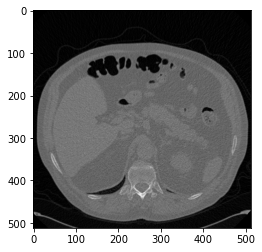

In [52]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata()
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(img, -1)
test_mask = np.expand_dims(mask, -1)


print(img.shape, mask.shape, type(img), type(mask))

# Visualize CT

#plt.imshow(img[:, :, 100], cmap = "gray")
#plt.show()

In [53]:
print(test_img.shape, test_mask.shape)

(512, 512, 662, 1) (512, 512, 662, 1)


# Model Creation

In [17]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [18]:
# Hyperparameters

batch_size = 1  # from torch notebook
learning_rate = 1e-2

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [49]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)
    
    # if(pretrained_weights):
    	# model.load_weights(pretrained_weights)

    return model

In [50]:
def compile_model(learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])


In [55]:
model = unet(input_size=(512,512,662,1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 331, 64), dtype=tf.float32, name=None), name='max_pooling3d_32/MaxPool3D:0', description="created by layer 'max_pooling3d_32'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 165, 128), dtype=tf.float32, name=None), name='max_pooling3d_33/MaxPool3D:0', description="created by layer 'max_pooling3d_33'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 82, 256), dtype=tf.float32, name=None), name='max_pooling3d_34/MaxPool3D:0', description="created by layer 'max_pooling3d_34'")


2022-03-09 11:11:37.755763: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 27.00MiB (rounded to 28311552)requested by op Mul
Current allocation summary follows.
2022-03-09 11:11:37.755810: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-03-09 11:11:37.755822: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 52, Chunks in use: 52. 13.0KiB allocated for chunks. 13.0KiB in use in bin. 5.9KiB client-requested in use in bin.
2022-03-09 11:11:37.755831: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 23, Chunks in use: 23. 12.0KiB allocated for chunks. 12.0KiB in use in bin. 11.5KiB client-requested in use in bin.
2022-03-09 11:11:37.755839: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 24, Chunks in use: 24. 25.5KiB allocated for chunks. 25.5KiB in use in bin. 24.0KiB client-request

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [47]:
model.summary()
model.output

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 66 0                                            
__________________________________________________________________________________________________
conv3d_108 (Conv3D)             (None, 512, 512, 662 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv3d_109 (Conv3D)             (None, 512, 512, 662 110656      conv3d_108[0][0]                 
__________________________________________________________________________________________________
max_pooling3d_20 (MaxPooling3D) (None, 256, 256, 331 0           conv3d_109[0][0]                 
____________________________________________________________________________________________

<KerasTensor: shape=(None, 512, 512, 3296, 1) dtype=float32 (created by layer 'conv3d_131')>

In [54]:
model.fit(x=test_img, y=test_mask)
# TODO troubleshoot incorrect dimensions

ValueError: in user code:

    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_4: expected shape=(None, 512, 512, 662, 1), found shape=(32, 512, 662, 1)
